# Exploratory Data Analysis

#### In order to better capture the behavior of the data, data from 4-hour intervals will be used.

In [64]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
import mplfinance as mpf # pip install mplfinance


In [65]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)

## 1.0 Closing price distribution

Text(0.5, 0, 'Precio (USD)')

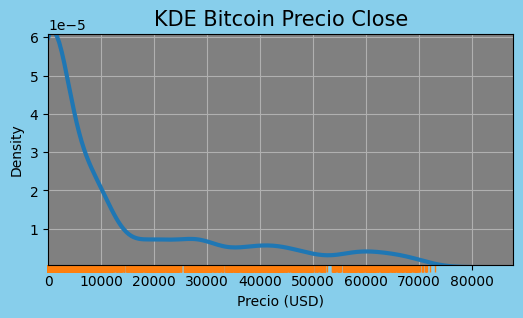

In [66]:

fig, ax = plt.subplots(figsize=(6, 3))
p = sns.kdeplot(data=df_1d, x="close", linewidth=3, ax=ax)
r = sns.rugplot(data=df_1d, x="close", ax=ax, height=-0.03, clip_on=False)
p.set(xlim=(0, None))
p.set_title("KDE Bitcoin Precio Close", fontsize=15)
p.set_facecolor('gray')
fig.set_facecolor('skyblue')
p.grid(visible=True)
p.set_xlabel("Precio (USD)")

The study data shows a majority distribution of prices below 20,000 (USD). This stage corresponds to the period between 2013 and September 2020. However, since 2021, the price has been in the 35,000 - 67,500 (USD) range.

Trying to model a time series with a very asymmetric distribution and different orders of magnitude over time can be complicated.

One strategy to try to minimize these problems is to model the changes (deltas) instead of the direct values. This could be further simplified by only indicating whether the price increases or decreases compared to the previous day.

Deltas represent the changes in the price of an asset over a given period of time (in this case, from one day to the next). Instead of analyzing the absolute price of Bitcoin, these changes are analyzed. Modeling deltas instead of Bitcoin price is a useful strategy to deal with high volatility and skewed distribution of data. By simplifying the analysis and obtaining a more manageable distribution, more robust and accurate models can be built.

While modeling deltas is a good practice, it does not guarantee a perfect prediction. The cryptocurrency market is highly volatile and affected by numerous factors.

## 1.1 Correlation of the features

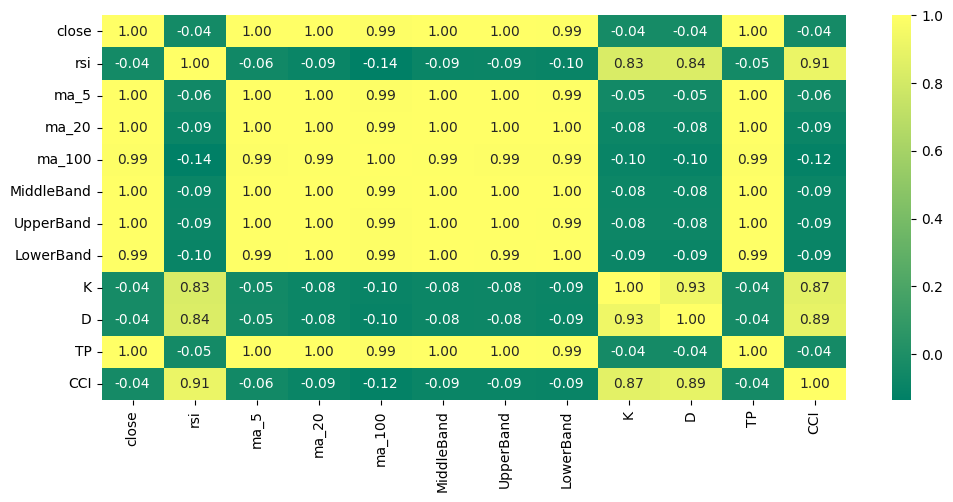

In [67]:
plt.figure(figsize=(12,5))
sns.heatmap(df_1d[['close', 'rsi', 'ma_5', 'ma_20', 'ma_100', 'MiddleBand',
       'UpperBand', 'LowerBand', 'K', 'D', 'TP', 'CCI']].corr(method='spearman'),annot=True,fmt='.2f',cmap='summer')
plt.show()

We can conclude that some of the synthetic variables provide us with certain information to explain the "close" variable, although taking into account that the most important value when making predictions is the last lag, that is, the value prior to the current one.

In [68]:
df_1d['date']=pd.to_datetime(df_1d['date'])
df_1d['year'] = df_1d['date'].apply(lambda x: x.year)
df_1d['quarter'] = df_1d['date'].apply(lambda x: x.quarter)
df_1d['month'] = df_1d['date'].apply(lambda x: x.month)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_15004\3388670007.py:34: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(text,(loc_x, loc_y),  textcoords="offset fontsize", ha='center',  fontsize=9, color='red' )


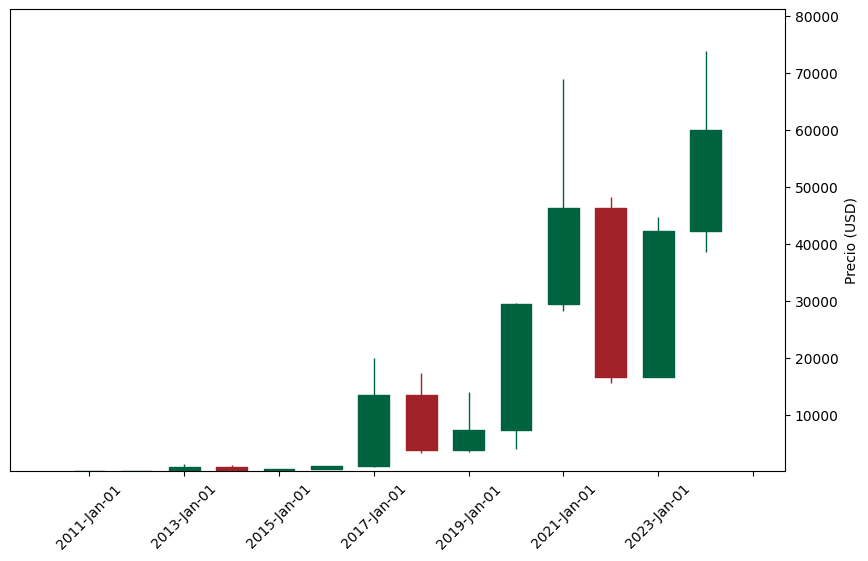

In [69]:

df_1d['date_time'] = df_1d['date']
df_1d.index = df_1d['date']
years = list(df_1d.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    year_open = df_1d.loc[df_1d.index.year == year, "open"].iloc[0]
    year_close = df_1d.loc[df_1d.index.year == year, "close"].iloc[-1]
    year_low = df_1d.loc[df_1d.index.year == year, "low"].min()
    year_high = df_1d.loc[df_1d.index.year == year, "high"].max()
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high])
df_plot = df_plot.T
df_plot = df_plot.set_axis(["open", "close", "low", "high"], axis=1)

df_plot["year_change"] = 100 * (df_plot["close"] - df_plot["open"]) / df_plot["open"]
df_plot.index = pd.to_datetime(df_plot.index, format='%Y') + pd.offsets.DateOffset(months=0, days=0)
annotations_list = []
max_high = df_plot["high"].max()

for year in years:
    df_aux = df_plot.loc[df_plot.index.year == year]
    if not df_aux.empty:
        loc_x = df_aux.index[0]
        loc_y = df_aux["high"].values[0] + (max_high * 0.05)
        text = "{:.1f}%".format(df_aux["year_change"].values[0])
        annotations_list.append((loc_x, loc_y, text))
        
fig, ax = plt.subplots(figsize=(10, 6))

mpf.plot(
    df_plot,type='candle', style='charles',ylabel='Precio (USD)',ax=ax,volume=False
)
for loc_x, loc_y, text in annotations_list:
    ax.annotate(text,(loc_x, loc_y),  textcoords="offset fontsize", ha='center',  fontsize=9, color='red' )
ax.set_ylim(df_plot["low"].min(), df_plot["high"].max() * 1.1)
plt.show()

We conclude then that there is a clear upward trend over the years with increasingly higher peaks, where volatility is also evident in certain periods of time. The years 2017 and 2021 stand out for their strong increases compared to the others.


C:\Users\Pablo\AppData\Local\Temp\ipykernel_15004\3322011151.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


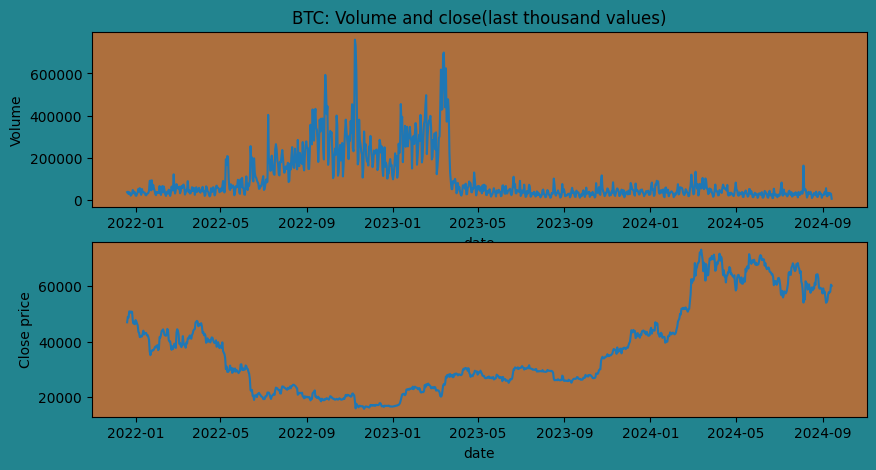

In [95]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=df_1d[-1000:], x='date', y='volume', ax=ax1)
ax1.set_title('BTC: Volume and close(last thousand values)')
ax1.set_ylabel('Volume')
sns.lineplot(data=df_1d[-1000:], x='date', y='close', ax=ax2)
ax2.set_ylabel('Close price')

fig.set_facecolor('#22848f')
ax1.set_facecolor('#ad6f3d')
ax2.set_facecolor('#ad6f3d')
fig.show()

Volume and price do not always move in the same direction. There are periods when the price increases or decreases significantly, while the volume remains relatively stable or even decreasing. We can also notice periods of high volatility in both price and volume. These usually coincide with important market news or macroeconomic events that generate uncertainty and increase the activity of traders.

Regarding the general trend, we assume that in the long term, there is an upward trend in the price of Bitcoin, despite short-term fluctuations. However, volume does not necessarily follow this trend. While volume is an important indicator, it should not be the only factor to consider when analyzing the cryptocurrency market.

## 1.3 Technical analysis

C:\Users\Pablo\AppData\Local\Temp\ipykernel_15004\277049030.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


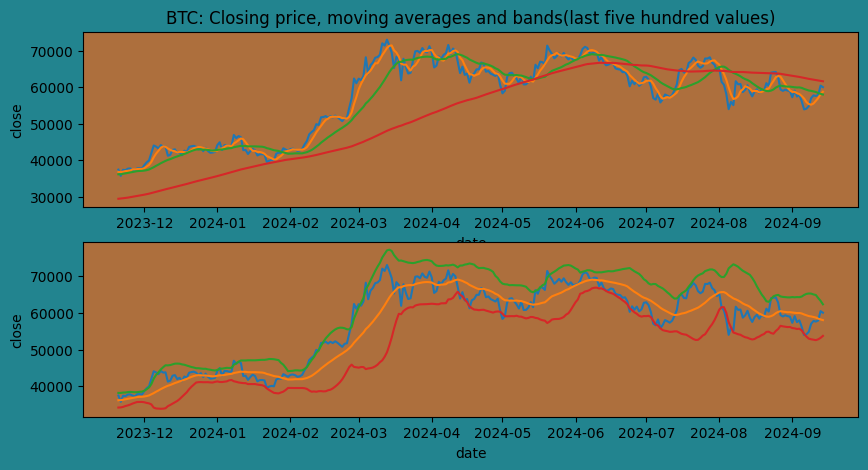

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
ax1.set_title('BTC: Closing price, moving averages and bands(last five hundred values)')
sns.lineplot(data=df_1d[-300:],x='date',y='close',ax=ax1)
sns.lineplot(data=df_1d[-300:],x='date',y='ma_5',ax=ax1)
sns.lineplot(data=df_1d[-300:],x='date',y='ma_20',ax=ax1)
sns.lineplot(data=df_1d[-300:],x='date',y='ma_100',ax=ax1)

sns.lineplot(data=df_1d[-300:],x='date',y='close',ax=ax2)
sns.lineplot(data=df_1d[-300:],x='date',y='MiddleBand',ax=ax2)
sns.lineplot(data=df_1d[-300:],x='date',y='UpperBand',ax=ax2)
sns.lineplot(data=df_1d[-300:],x='date',y='LowerBand',ax=ax2)
fig.set_facecolor('#22848f')
ax1.set_facecolor('#ad6f3d')
ax2.set_facecolor('#ad6f3d')

fig.show()